<ipython-input-2-4f0924f7e61b>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_labels = noise(torch.tensor(train_set.targets), epsilon)


Data loaded successfully...
[epoch 1, iter   200] loss: 2.299
[epoch 1, iter   400] loss: 2.288
[epoch 1, iter   600] loss: 2.286
[epoch 1, iter   800] loss: 2.283
epoch 1: train_acc 16.305, test_acc 65.750
[epoch 2, iter   200] loss: 2.281
[epoch 2, iter   400] loss: 2.274
[epoch 2, iter   600] loss: 2.279
[epoch 2, iter   800] loss: 2.277
epoch 2: train_acc 17.438, test_acc 73.660
[epoch 3, iter   200] loss: 2.274
[epoch 3, iter   400] loss: 2.277
[epoch 3, iter   600] loss: 2.277
[epoch 3, iter   800] loss: 2.274
epoch 3: train_acc 17.783, test_acc 76.520
[epoch 4, iter   200] loss: 2.272
[epoch 4, iter   400] loss: 2.271
[epoch 4, iter   600] loss: 2.270
[epoch 4, iter   800] loss: 2.273
epoch 4: train_acc 17.878, test_acc 75.870
[epoch 5, iter   200] loss: 2.263
[epoch 5, iter   400] loss: 2.273
[epoch 5, iter   600] loss: 2.269
[epoch 5, iter   800] loss: 2.272
epoch 5: train_acc 18.357, test_acc 78.030
[epoch 6, iter   200] loss: 2.263
[epoch 6, iter   400] loss: 2.262
[epoch 6,

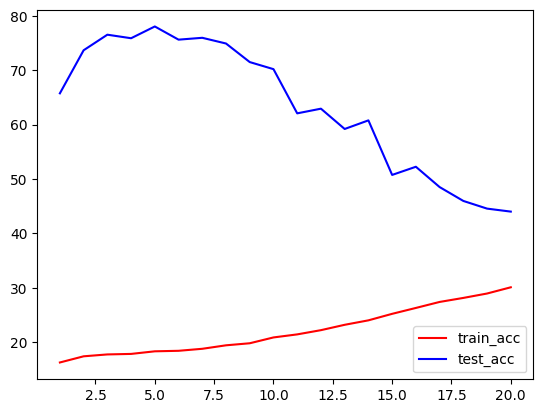

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools

train_batch_size = 64
test_batch_size = 1000

class Net(nn.Module):
   def __init__(self):
       super(Net, self).__init__()
       self.conv1 = nn.Conv2d(1, 6, 5, stride=1, padding=2)
       self.conv2 = nn.Conv2d(6, 16, 5, stride=1, padding=0)
       self.fc1 = nn.Linear(16*5*5, 120)
       self.fc2 = nn.Linear(120, 84)
       self.fc3 = nn.Linear(84, 10)  # Change from 10 to 10 for Fashion-MNIST
   def forward(self, x):
       x = F.max_pool2d(F.relu(self.conv1(x)), 2)
       x = F.max_pool2d(F.relu(self.conv2(x)), 2)
       x = x.view(-1, self.num_flat_features(x))
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = self.fc3(x)
       return x
   def num_flat_features(self, x):
       x_size = x.size()[1:]
       num = 1
       for n in x_size:
           num *= n
       return num

def noise(labels, noise_rate=0.8):
    counts = Counter(labels.tolist())
    rates = [int(noise_rate * counts[i]) for i in range(10)]
    noisy = [i.item() for i in labels]

    for idx in range(len(labels)):
        current = labels[idx]
        if rates[current] > 0:
            rates[current] -= 1
            random = torch.randint(0, 10, (1,))
            while random == labels[idx]:
                random = torch.randint(0, 10, (1,))
            noisy[idx] = random.item()

    return noisy

def load_data(noise_rate=0.8):
   transform = transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
   ])
   train_set = tv.datasets.FashionMNIST(
       root='./data',
       train=True,
       download=True,
       transform=transform
   )
   epsilon = noise_rate
   noisy_labels = noise(torch.tensor(train_set.targets), epsilon)
   train_set.targets = torch.tensor(noisy_labels)

   train_loader = torch.utils.data.DataLoader(
       train_set,
       batch_size=train_batch_size,
       shuffle=True,
       num_workers=2
   )
   test_set = tv.datasets.FashionMNIST(
       root='./data',
       train=False,
       download=True,
       transform=transform
   )
   test_loader = torch.utils.data.DataLoader(
       test_set,
       batch_size=test_batch_size,
       shuffle=False,
       num_workers=2
   )
   print("Data loaded successfully...")
   return train_loader, test_loader

def accuracy(model, x):
   with torch.no_grad():
       correct = 0
       total = 0
       for data in x:
           images, labels = data
           outputs = model(images)
           _, predicted = torch.max(outputs.data, 1)
           total += labels.size(0)
           correct += (predicted == labels).sum().item()

       return (100 * correct / total)

def train(train_loader, test_loader, model, criterion, optimizer, epoch):
   model.train()
   running_loss = 0
   for i, data in enumerate(train_loader, 0):
       inputs, labels = data
       optimizer.zero_grad()
       outputs = model(inputs)
       loss = criterion(outputs, labels)
       loss.backward()
       optimizer.step()

       running_loss += loss.item()
       if i % 200 == 199:
           print("[epoch %d, iter %5d] loss: %.3f" % (epoch+1, i+1, running_loss / 200))
           running_loss = 0.0
   train_acc = accuracy(model, train_loader)
   test_acc = accuracy(model, test_loader)
   print("epoch %d: train_acc %.3f, test_acc %.3f" % (epoch+1, train_acc, test_acc))
   return train_acc, test_acc

def display(train_acc, test_acc):
   fig, ax = plt.subplots()
   ax.plot(range(1, len(train_acc) + 1), train_acc, color='r', label='train_acc')
   ax.plot(range(1, len(test_acc) + 1), test_acc, color='b', label='test_acc')
   ax.legend(loc='lower right')
   plt.show()

if __name__ == '__main__':
   # input Fashion-MNIST
   train_loader, test_loader = load_data()
   # new model
   net = Net()

   # training
   learning_rate = 0.001
   momentum = 0.9
   max_epoch = 20
   criterion = nn.CrossEntropyLoss()
   optimizer = optim.Adam(net.parameters(), lr=learning_rate)

   train_acc = []
   test_acc = []
   for epoch in range(max_epoch):
       train_acc_t, test_acc_t = train(train_loader, test_loader, net, criterion, optimizer, epoch)
       train_acc.append(train_acc_t)
       test_acc.append(test_acc_t)

   display(train_acc, test_acc)
